In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tools.SP100Stock import SP100Stocks
from models import TGCN, train, measure_accuracy, get_confusion_matrix

/home/alrodriguezg/U/s5/gnn/GNN_paper/code/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def future_close_price_to_buy_sell_class(sample: Data, threshold: float = 0.01):
	"""
	Transforms the target y to a three-class classification:
	- Down (0): return < -threshold
	- Neutral (1): -threshold <= return <= threshold
	- Up (2): return > threshold
	:param sample: Data sample
	:param threshold: Threshold for categorizing returns (default: 0.01 = 1%)
	:return: The transformed sample
	"""
	market_return = ((sample.close_price_y[:, -1] - sample.close_price[:, -1]) / sample.close_price[:, -1]).mean()
	sample.returns = ((sample.close_price_y[:, -1] - sample.close_price[:, -1]) / sample.close_price[:, -1]).unsqueeze(1)
	sample.market_return = market_return
	
	# Create three-class labels: 0=Down, 1=Neutral, 2=Up
	sample.y = torch.zeros_like(sample.returns, dtype=torch.long).squeeze(1)
	sample.y[sample.returns.squeeze(1) < -threshold] = 0  # Down
	sample.y[(sample.returns.squeeze(1) >= -threshold) & (sample.returns.squeeze(1) <= threshold)] = 1  # Neutral
	sample.y[sample.returns.squeeze(1) > threshold] = 2  # Up
	
	return sample

In [3]:
from functools import partial

weeks_ahead = 1
threshold = 0.01  # 1% threshold for neutral zone

# Create a partial function with the threshold parameter
transform_with_threshold = partial(future_close_price_to_buy_sell_class, threshold=threshold)

dataset = SP100Stocks(root="data/", adj_file_name='hybrid_adj.npy', future_window=weeks_ahead * 5, force_reload=True, transform=transform_with_threshold)
dataset, dataset[0]

Processing...


Loading and processing data for PyG format...
Values DataFrame shape: (69898, 10)
Values index levels: ['Symbol', 'Date']
Unique symbols in values: 100
Adjacency matrix shape: (100, 100)
Number of nodes (from adj): 100
Number of edges: 720
Unique symbols count: 100
Unique dates count: 699

Pivoting data to align stocks and timestamps...
Feature columns (excluding Close): 9
Features: ['SimpleReturn', 'LogReturn', 'Ret_1W', 'Ret_2W', 'Ret_1M', 'Ret_2M', 'Norm_Ret', 'RSI', 'MACD']
Pivoted shape (Date x Symbol): (699, 100)

Final array shapes:
  x (features): (100, 699, 9)
  close_prices: (100, 699)
  Expected x shape: (nodes_nb=100, timestamps_nb=699, features_nb=9)
  After transpose: x shape = torch.Size([100, 9, 699])
  Expected: (nodes_nb=100, features_nb=9, timestamps_nb=699)

Building edge index and edge weights...
  Created 720 edges



Done!


(SP100Stocks(669),
 Data(x=[100, 9, 25], edge_index=[2, 720], y=[100], edge_weight=[720], close_price=[100, 25], close_price_y=[100, 5], returns=[100, 1], market_return=0.013026706874370575))

In [4]:
for i in range(0, 10):
	label = int(dataset[i].y[i].item())
	label_name = ['Down', 'Neutral', 'Up'][label]
	print(f"Stock return: {dataset[i].returns[i].item() * 100:.2f}%, trend: {label_name} (class {label})")

Stock return: 4.80%, trend: Up (class 2)
Stock return: -0.59%, trend: Neutral (class 1)
Stock return: -0.96%, trend: Neutral (class 1)
Stock return: 5.96%, trend: Up (class 2)
Stock return: 3.67%, trend: Up (class 2)
Stock return: 2.84%, trend: Up (class 2)
Stock return: 11.09%, trend: Up (class 2)
Stock return: -3.18%, trend: Down (class 0)
Stock return: -1.51%, trend: Down (class 0)
Stock return: 1.08%, trend: Up (class 2)


In [5]:
train_part = .9
batch_size = 32

train_dataset, test_dataset = dataset[:int(train_part * len(dataset))], dataset[int(train_part * len(dataset)):]
print(f"Train dataset: {len(train_dataset)}, Test dataset: {len(test_dataset)}")
train_dataloader, test_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

Train dataset: 602, Test dataset: 67


In [6]:
in_channels, out_channels, hidden_size, layers_nb, dropout = dataset[0].x.shape[-2], 3, 16, 2, .3  # 3 classes: Down, Neutral, Up
model = TGCN(in_channels, out_channels, hidden_size, layers_nb)

lr, weight_decay, num_epochs = 0.005, 1e-5, 100
	
# Use CrossEntropyLoss for multi-class classification (3 classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
model

TGCN(
  (cells): ModuleList(
    (0): TGCNCell(
      (gcn): GCN(
        (convs): ModuleList(
          (0): GCNConv(9, 16)
          (1): GCNConv(16, 16)
        )
      )
      (lin_u): Linear(in_features=41, out_features=16, bias=True)
      (lin_r): Linear(in_features=41, out_features=16, bias=True)
      (lin_c): Linear(in_features=41, out_features=16, bias=True)
    )
    (1): TGCNCell(
      (gcn): GCN(
        (convs): ModuleList(
          (0-1): 2 x GCNConv(16, 16)
        )
      )
      (lin_u): Linear(in_features=48, out_features=16, bias=True)
      (lin_r): Linear(in_features=48, out_features=16, bias=True)
      (lin_c): Linear(in_features=48, out_features=16, bias=True)
    )
  )
  (out): Sequential(
    (0): Linear(in_features=16, out_features=3, bias=True)
    (1): Identity()
  )
)

In [7]:
train(model, optimizer, criterion, train_dataloader, test_dataloader, num_epochs, "UpDownTrend_hybrid_threshold", measure_acc=True)

Epochs: 100%|██████████| 100/100 [27:12<00:00, 16.32s/it, Batch=100.0%]


In [8]:
torch.save(model.state_dict(), f"models/saved_models/UpDownTrend_hybrid_threshold_{model.__class__.__name__}.pt")

In [9]:
full_train_data = next(iter(DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)))
acc, cm = measure_accuracy(model, full_train_data), get_confusion_matrix(model, full_train_data)

print(f"Train accuracy: {acc * 100:.1f}%\nTrain confusion matrix:\n{cm}")

KeyboardInterrupt: 

In [28]:
acc, cm = measure_accuracy(model, next(iter(train_dataloader))), get_confusion_matrix(model, next(iter(train_dataloader)))

print(f"Test accuracy: {acc * 100:.1f}%\nTest confusion matrix:\n{cm}")

Test accuracy: 79.8%
Test confusion matrix:
[[ 935  351]
 [ 319 1595]]


In [29]:
acc, cm = measure_accuracy(model, next(iter(test_dataset))), get_confusion_matrix(model, next(iter(test_dataset)))

print(f"Test accuracy: {acc * 100:.1f}%\nTest confusion matrix:\n{cm}")

Test accuracy: 63.0%
Test confusion matrix:
[[28 17]
 [20 35]]


## Pearson graph prediction 

In [9]:
# Load the saved model
in_channels, out_channels, hidden_size, layers_nb = dataset[0].x.shape[-2], 1, 16, 2
model = TGCN(in_channels, out_channels, hidden_size, layers_nb)

# Load the saved state dict
model_path = f"models/saved_models/UpDownTrend_{model.__class__.__name__}.pt"
model.load_state_dict(torch.load(model_path))
model.eval()

print(f"Model loaded successfully from {model_path}")
print(f"Model architecture: {model.__class__.__name__}")
print(f"Parameters: in_channels={in_channels}, out_channels={out_channels}, hidden_size={hidden_size}, layers_nb={layers_nb}")

Model loaded successfully from models/saved_models/UpDownTrend_TGCN.pt
Model architecture: TGCN
Parameters: in_channels=9, out_channels=1, hidden_size=16, layers_nb=2


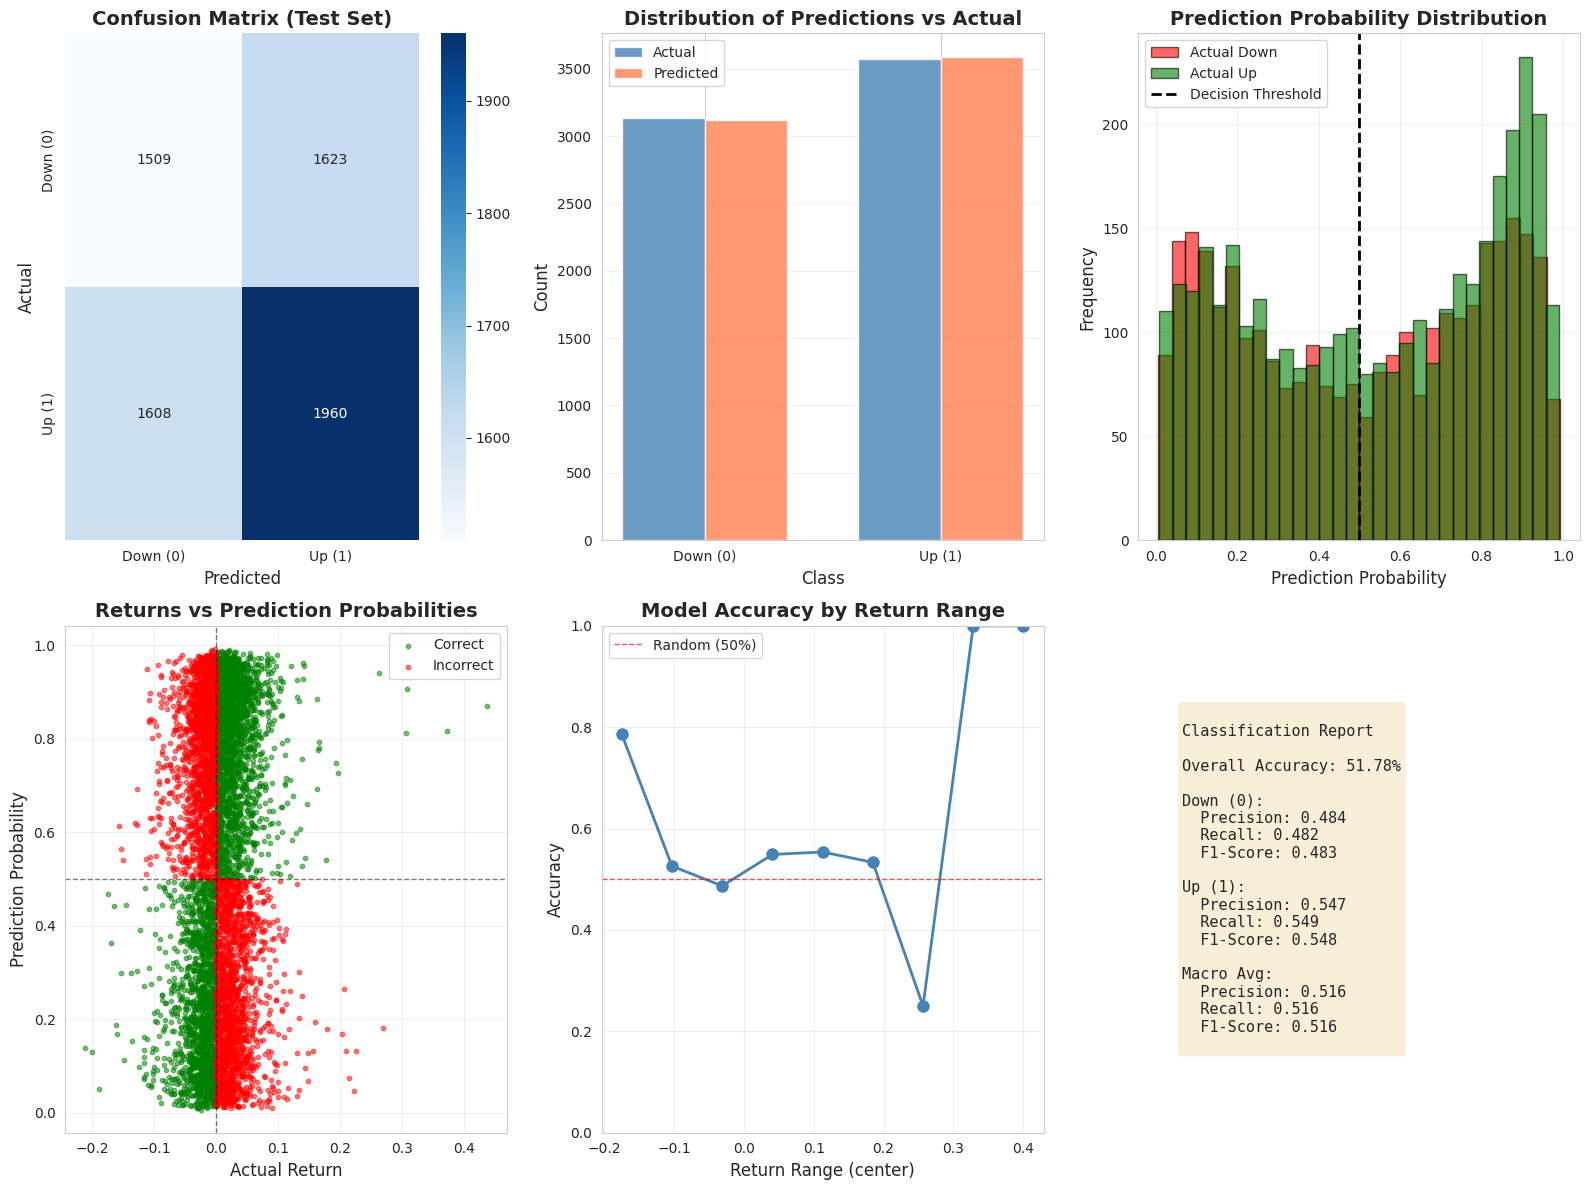


PREDICTION VISUALIZATION SUMMARY
Total predictions: 6700
Overall accuracy: 51.78%
Predicted Up: 3583 (53.48%)
Actual Up: 3568 (53.25%)
Average prediction probability: 0.524
Average actual return: 0.0037 (0.37%)



In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Get test data
test_data = next(iter(test_dataloader))
model.eval()
with torch.no_grad():
    logits = model(test_data.x, test_data.edge_index, test_data.edge_weight)
    probs = torch.sigmoid(logits).squeeze()
    predictions = (probs >= 0.5).float()
    actual = test_data.y.squeeze()

# Flatten predictions and actuals (since we have 100 stocks per sample)
preds_flat = predictions.cpu().numpy().flatten()
actuals_flat = actual.cpu().numpy().flatten()
probs_flat = probs.cpu().numpy().flatten()

# Create figure with subplots
fig = plt.figure(figsize=(16, 12))

# 1. Confusion Matrix Heatmap
ax1 = plt.subplot(2, 3, 1)
cm = confusion_matrix(actuals_flat, preds_flat)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, 
            xticklabels=['Down (0)', 'Up (1)'], 
            yticklabels=['Down (0)', 'Up (1)'])
ax1.set_title('Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Actual', fontsize=12)
ax1.set_xlabel('Predicted', fontsize=12)

# 2. Prediction Distribution
ax2 = plt.subplot(2, 3, 2)
pred_counts = np.bincount(preds_flat.astype(int), minlength=2)
actual_counts = np.bincount(actuals_flat.astype(int), minlength=2)
x = np.arange(2)
width = 0.35
ax2.bar(x - width/2, actual_counts, width, label='Actual', alpha=0.8, color='steelblue')
ax2.bar(x + width/2, pred_counts, width, label='Predicted', alpha=0.8, color='coral')
ax2.set_xlabel('Class', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Distribution of Predictions vs Actual', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(['Down (0)', 'Up (1)'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Prediction Probabilities Distribution
ax3 = plt.subplot(2, 3, 3)
ax3.hist(probs_flat[actuals_flat == 0], bins=30, alpha=0.6, label='Actual Down', color='red', edgecolor='black')
ax3.hist(probs_flat[actuals_flat == 1], bins=30, alpha=0.6, label='Actual Up', color='green', edgecolor='black')
ax3.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
ax3.set_xlabel('Prediction Probability', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Returns vs Predictions
ax4 = plt.subplot(2, 3, 4)
returns_flat = test_data.returns.squeeze().cpu().numpy().flatten()
# Scatter plot colored by prediction correctness
correct_mask = (preds_flat == actuals_flat)
ax4.scatter(returns_flat[correct_mask], probs_flat[correct_mask], 
           alpha=0.5, label='Correct', color='green', s=10)
ax4.scatter(returns_flat[~correct_mask], probs_flat[~correct_mask], 
           alpha=0.5, label='Incorrect', color='red', s=10)
ax4.axhline(y=0.5, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax4.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax4.set_xlabel('Actual Return', fontsize=12)
ax4.set_ylabel('Prediction Probability', fontsize=12)
ax4.set_title('Returns vs Prediction Probabilities', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Accuracy by Return Range
ax5 = plt.subplot(2, 3, 5)
return_bins = np.linspace(returns_flat.min(), returns_flat.max(), 10)
bin_indices = np.digitize(returns_flat, return_bins)
bin_accuracies = []
bin_centers = []
for i in range(1, len(return_bins)):
    mask = (bin_indices == i)
    if mask.sum() > 0:
        bin_acc = (preds_flat[mask] == actuals_flat[mask]).mean()
        bin_accuracies.append(bin_acc)
        bin_centers.append((return_bins[i-1] + return_bins[i]) / 2)
ax5.plot(bin_centers, bin_accuracies, marker='o', linewidth=2, markersize=8, color='steelblue')
ax5.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Random (50%)')
ax5.set_xlabel('Return Range (center)', fontsize=12)
ax5.set_ylabel('Accuracy', fontsize=12)
ax5.set_title('Model Accuracy by Return Range', fontsize=14, fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)
ax5.set_ylim([0, 1])

# 6. Classification Report Summary
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
report = classification_report(actuals_flat, preds_flat, 
                               target_names=['Down (0)', 'Up (1)'], 
                               output_dict=True)
report_text = f"""
Classification Report

Overall Accuracy: {report['accuracy']:.2%}

Down (0):
  Precision: {report['Down (0)']['precision']:.3f}
  Recall: {report['Down (0)']['recall']:.3f}
  F1-Score: {report['Down (0)']['f1-score']:.3f}

Up (1):
  Precision: {report['Up (1)']['precision']:.3f}
  Recall: {report['Up (1)']['recall']:.3f}
  F1-Score: {report['Up (1)']['f1-score']:.3f}

Macro Avg:
  Precision: {report['macro avg']['precision']:.3f}
  Recall: {report['macro avg']['recall']:.3f}
  F1-Score: {report['macro avg']['f1-score']:.3f}
"""
ax6.text(0.1, 0.5, report_text, fontsize=11, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{'='*60}")
print("PREDICTION VISUALIZATION SUMMARY")
print(f"{'='*60}")
print(f"Total predictions: {len(preds_flat)}")
print(f"Overall accuracy: {(preds_flat == actuals_flat).mean():.2%}")
print(f"Predicted Up: {preds_flat.sum():.0f} ({preds_flat.mean():.2%})")
print(f"Actual Up: {actuals_flat.sum():.0f} ({actuals_flat.mean():.2%})")
print(f"Average prediction probability: {probs_flat.mean():.3f}")
print(f"Average actual return: {returns_flat.mean():.4f} ({returns_flat.mean()*100:.2f}%)")
print(f"{'='*60}\n")


## Hybrid graph prediction

In [21]:
# Load the saved model
in_channels, out_channels, hidden_size, layers_nb = dataset[0].x.shape[-2], 1, 16, 2
model = TGCN(in_channels, out_channels, hidden_size, layers_nb)

# Load the saved state dict
model_path = f"models/saved_models/UpDownTrend_hybrid_{model.__class__.__name__}.pt"
model.load_state_dict(torch.load(model_path))
model.eval()

print(f"Model loaded successfully from {model_path}")
print(f"Model architecture: {model.__class__.__name__}")
print(f"Parameters: in_channels={in_channels}, out_channels={out_channels}, hidden_size={hidden_size}, layers_nb={layers_nb}")

Model loaded successfully from models/saved_models/UpDownTrend_hybrid_TGCN.pt
Model architecture: TGCN
Parameters: in_channels=9, out_channels=1, hidden_size=16, layers_nb=2


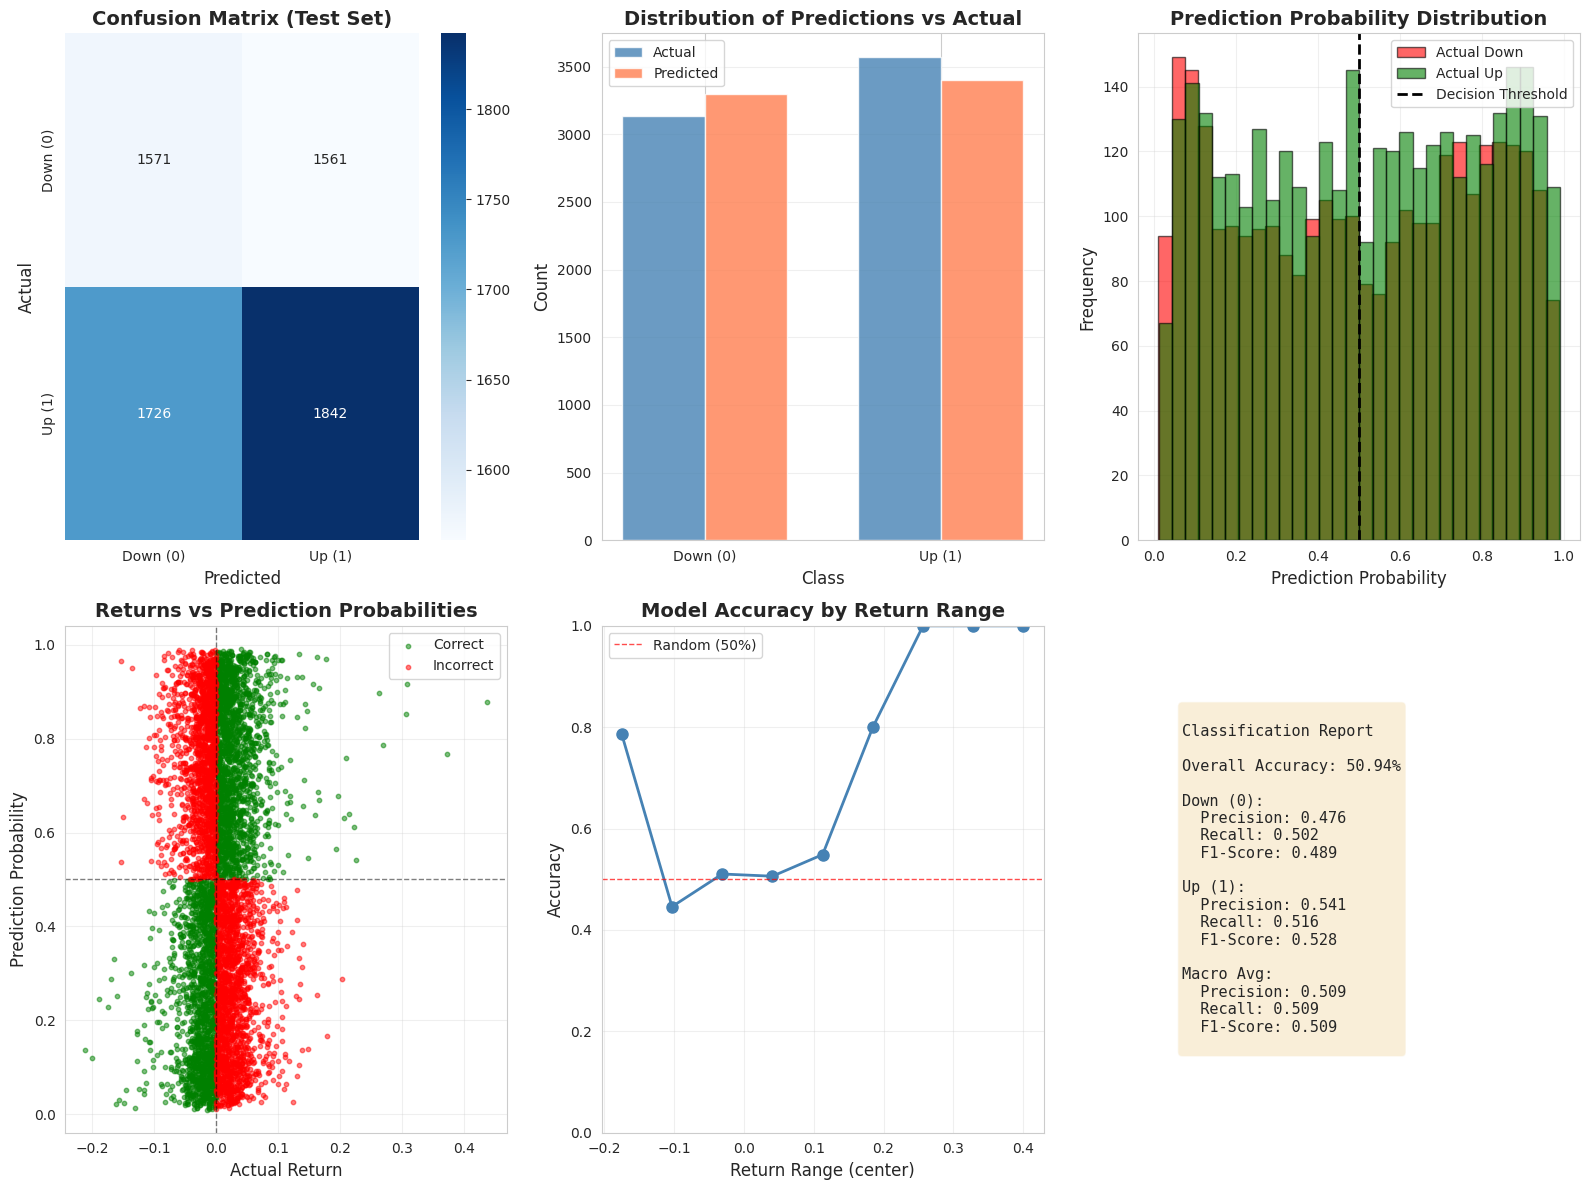


PREDICTION VISUALIZATION SUMMARY
Total predictions: 6700
Overall accuracy: 50.94%
Predicted Up: 3403 (50.79%)
Actual Up: 3568 (53.25%)
Average prediction probability: 0.506
Average actual return: 0.0037 (0.37%)



In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Get test data
test_data = next(iter(test_dataloader))
model.eval()
with torch.no_grad():
    logits = model(test_data.x, test_data.edge_index, test_data.edge_weight)
    probs = torch.sigmoid(logits).squeeze()
    predictions = (probs >= 0.5).float()
    actual = test_data.y.squeeze()

# Flatten predictions and actuals (since we have 100 stocks per sample)
preds_flat = predictions.cpu().numpy().flatten()
actuals_flat = actual.cpu().numpy().flatten()
probs_flat = probs.cpu().numpy().flatten()

# Create figure with subplots
fig = plt.figure(figsize=(16, 12))

# 1. Confusion Matrix Heatmap
ax1 = plt.subplot(2, 3, 1)
cm = confusion_matrix(actuals_flat, preds_flat)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, 
            xticklabels=['Down (0)', 'Up (1)'], 
            yticklabels=['Down (0)', 'Up (1)'])
ax1.set_title('Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Actual', fontsize=12)
ax1.set_xlabel('Predicted', fontsize=12)

# 2. Prediction Distribution
ax2 = plt.subplot(2, 3, 2)
pred_counts = np.bincount(preds_flat.astype(int), minlength=2)
actual_counts = np.bincount(actuals_flat.astype(int), minlength=2)
x = np.arange(2)
width = 0.35
ax2.bar(x - width/2, actual_counts, width, label='Actual', alpha=0.8, color='steelblue')
ax2.bar(x + width/2, pred_counts, width, label='Predicted', alpha=0.8, color='coral')
ax2.set_xlabel('Class', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Distribution of Predictions vs Actual', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(['Down (0)', 'Up (1)'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Prediction Probabilities Distribution
ax3 = plt.subplot(2, 3, 3)
ax3.hist(probs_flat[actuals_flat == 0], bins=30, alpha=0.6, label='Actual Down', color='red', edgecolor='black')
ax3.hist(probs_flat[actuals_flat == 1], bins=30, alpha=0.6, label='Actual Up', color='green', edgecolor='black')
ax3.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
ax3.set_xlabel('Prediction Probability', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Returns vs Predictions
ax4 = plt.subplot(2, 3, 4)
returns_flat = test_data.returns.squeeze().cpu().numpy().flatten()
# Scatter plot colored by prediction correctness
correct_mask = (preds_flat == actuals_flat)
ax4.scatter(returns_flat[correct_mask], probs_flat[correct_mask], 
           alpha=0.5, label='Correct', color='green', s=10)
ax4.scatter(returns_flat[~correct_mask], probs_flat[~correct_mask], 
           alpha=0.5, label='Incorrect', color='red', s=10)
ax4.axhline(y=0.5, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax4.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax4.set_xlabel('Actual Return', fontsize=12)
ax4.set_ylabel('Prediction Probability', fontsize=12)
ax4.set_title('Returns vs Prediction Probabilities', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Accuracy by Return Range
ax5 = plt.subplot(2, 3, 5)
return_bins = np.linspace(returns_flat.min(), returns_flat.max(), 10)
bin_indices = np.digitize(returns_flat, return_bins)
bin_accuracies = []
bin_centers = []
for i in range(1, len(return_bins)):
    mask = (bin_indices == i)
    if mask.sum() > 0:
        bin_acc = (preds_flat[mask] == actuals_flat[mask]).mean()
        bin_accuracies.append(bin_acc)
        bin_centers.append((return_bins[i-1] + return_bins[i]) / 2)
ax5.plot(bin_centers, bin_accuracies, marker='o', linewidth=2, markersize=8, color='steelblue')
ax5.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Random (50%)')
ax5.set_xlabel('Return Range (center)', fontsize=12)
ax5.set_ylabel('Accuracy', fontsize=12)
ax5.set_title('Model Accuracy by Return Range', fontsize=14, fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)
ax5.set_ylim([0, 1])

# 6. Classification Report Summary
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
report = classification_report(actuals_flat, preds_flat, 
                               target_names=['Down (0)', 'Up (1)'], 
                               output_dict=True)
report_text = f"""
Classification Report

Overall Accuracy: {report['accuracy']:.2%}

Down (0):
  Precision: {report['Down (0)']['precision']:.3f}
  Recall: {report['Down (0)']['recall']:.3f}
  F1-Score: {report['Down (0)']['f1-score']:.3f}

Up (1):
  Precision: {report['Up (1)']['precision']:.3f}
  Recall: {report['Up (1)']['recall']:.3f}
  F1-Score: {report['Up (1)']['f1-score']:.3f}

Macro Avg:
  Precision: {report['macro avg']['precision']:.3f}
  Recall: {report['macro avg']['recall']:.3f}
  F1-Score: {report['macro avg']['f1-score']:.3f}
"""
ax6.text(0.1, 0.5, report_text, fontsize=11, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{'='*60}")
print("PREDICTION VISUALIZATION SUMMARY")
print(f"{'='*60}")
print(f"Total predictions: {len(preds_flat)}")
print(f"Overall accuracy: {(preds_flat == actuals_flat).mean():.2%}")
print(f"Predicted Up: {preds_flat.sum():.0f} ({preds_flat.mean():.2%})")
print(f"Actual Up: {actuals_flat.sum():.0f} ({actuals_flat.mean():.2%})")
print(f"Average prediction probability: {probs_flat.mean():.3f}")
print(f"Average actual return: {returns_flat.mean():.4f} ({returns_flat.mean()*100:.2f}%)")
print(f"{'='*60}\n")

As we can appreciate, the results obtained on both graph roughly surpass 50% of accuracy (almost as good as flipping a coin). This suggest that the current experiment design could be inpractical. A likely explanation is that the model is exposed to a lot of noise. An increase of 0.001% will be categorized upward as well as an increase of 1%. Therefor a fundamental improvement could be adding a new prediction label "neutral" that label those insignificant variations as a new category and then handle better that noise.

## Neutral label

In [11]:
# Load the saved model
in_channels, out_channels, hidden_size, layers_nb = dataset[0].x.shape[-2], 3, 16, 2
model = TGCN(in_channels, out_channels, hidden_size, layers_nb)

# Load the saved state dict
model_path = f"models/saved_models/UpDownTrend_hybrid_threshold_{model.__class__.__name__}.pt"
model.load_state_dict(torch.load(model_path))
model.eval()

print(f"Model loaded successfully from {model_path}")
print(f"Model architecture: {model.__class__.__name__}")
print(f"Parameters: in_channels={in_channels}, out_channels={out_channels}, hidden_size={hidden_size}, layers_nb={layers_nb}")

Model loaded successfully from models/saved_models/UpDownTrend_hybrid_threshold_TGCN.pt
Model architecture: TGCN
Parameters: in_channels=9, out_channels=3, hidden_size=16, layers_nb=2


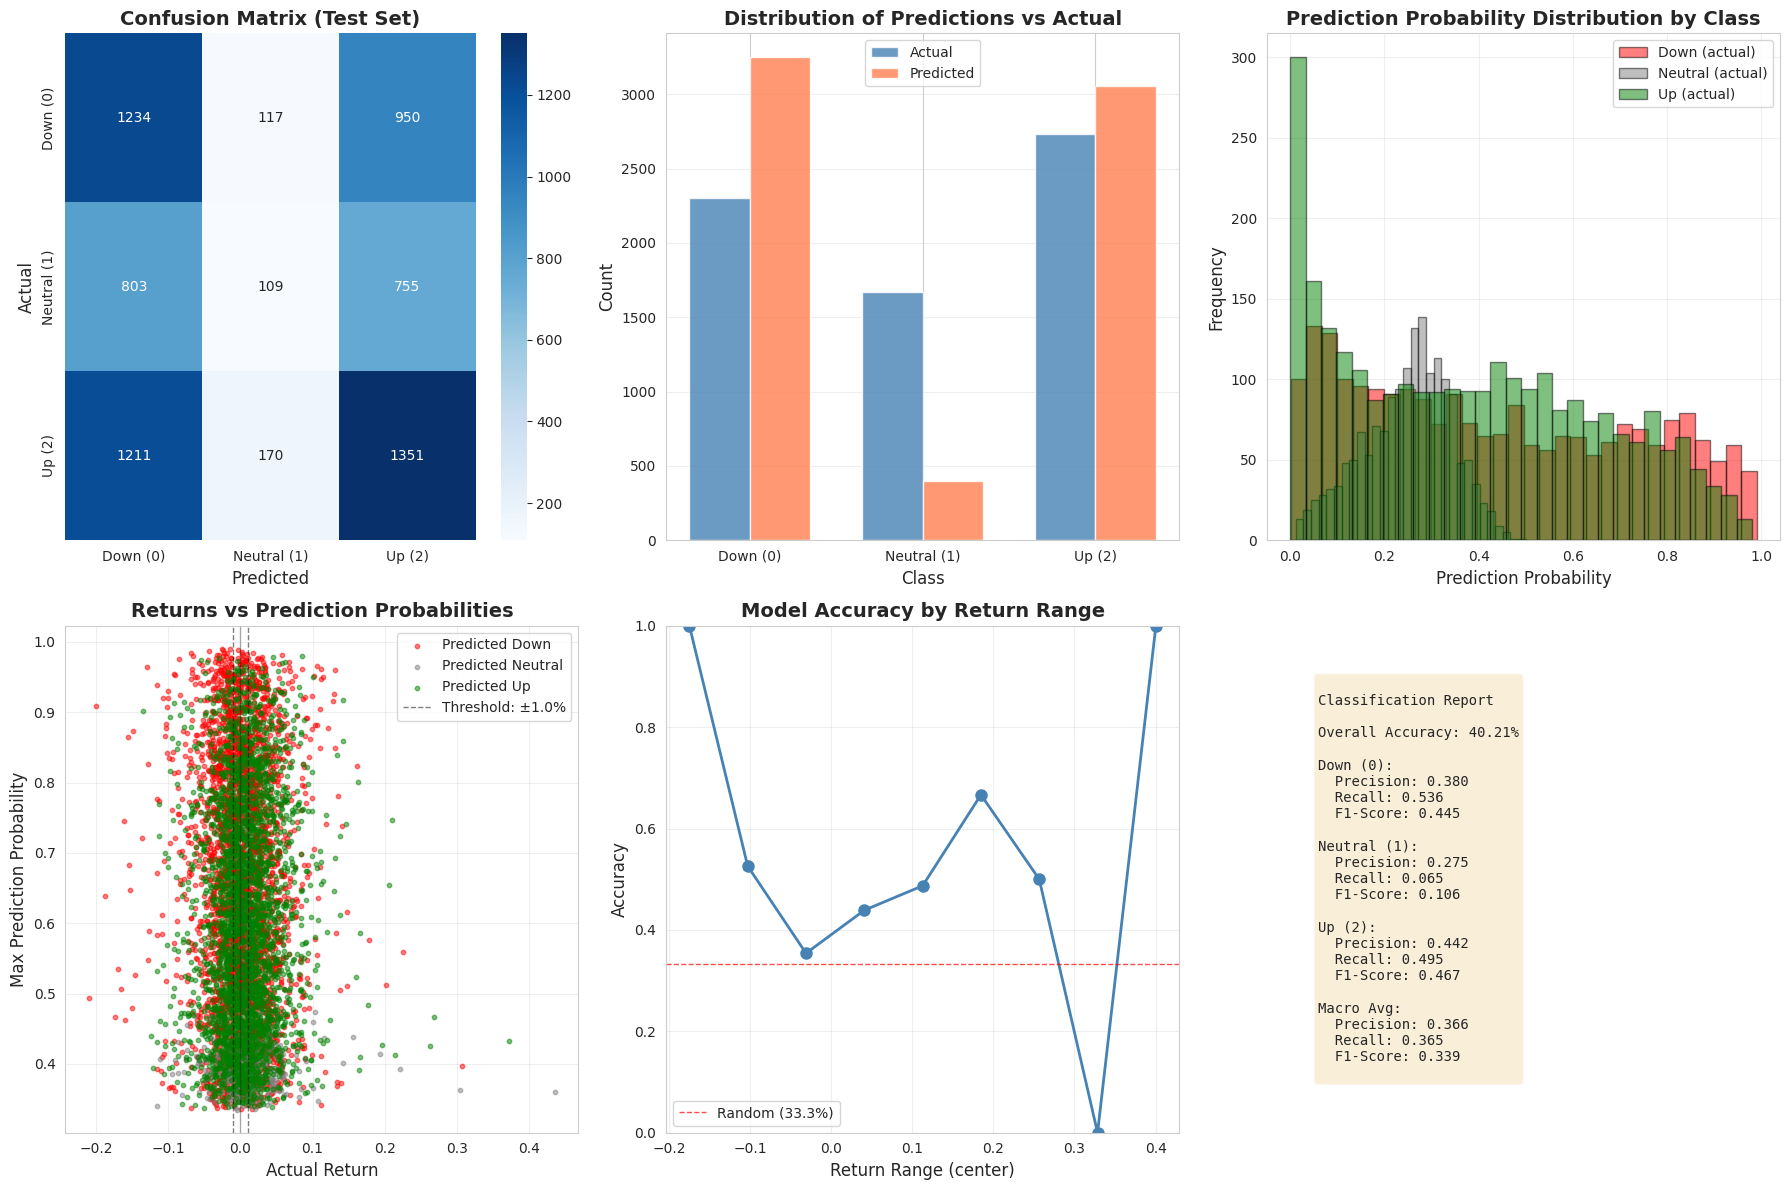


PREDICTION VISUALIZATION SUMMARY
Total predictions: 6700
Overall accuracy: 40.21%

Class Distribution (Actual):
  Down (0):    2301 (34.34%)
  Neutral (1):  1667 (24.88%)
  Up (2):      2732 (40.78%)

Class Distribution (Predicted):
  Down (0):    3248 (48.48%)
  Neutral (1):   396 ( 5.91%)
  Up (2):      3056 (45.61%)

Average max prediction probability: 0.617
Average actual return: 0.0037 (0.37%)
Threshold used: ±1.00%



In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn.functional as F

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

# Get test data
test_data = next(iter(test_dataloader))
model.eval()
with torch.no_grad():
    logits = model(test_data.x, test_data.edge_index, test_data.edge_weight)
    # Use softmax for multi-class classification (3 classes)
    probs = F.softmax(logits, dim=-1)  # Shape: (nodes, 3)
    predictions = probs.argmax(dim=-1)  # Get predicted class (0, 1, or 2)
    actual = test_data.y.squeeze()

# Flatten predictions and actuals (since we have 100 stocks per sample)
preds_flat = predictions.cpu().numpy().flatten()
actuals_flat = actual.cpu().numpy().flatten()
# Get max probability for each prediction
probs_max = probs.max(dim=-1)[0].cpu().numpy().flatten()
# Get probabilities for each class
probs_down = probs[:, 0].cpu().numpy().flatten()
probs_neutral = probs[:, 1].cpu().numpy().flatten()
probs_up = probs[:, 2].cpu().numpy().flatten()

# Create figure with subplots
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix Heatmap
ax1 = plt.subplot(2, 3, 1)
cm = confusion_matrix(actuals_flat, preds_flat, labels=[0, 1, 2])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, 
            xticklabels=['Down (0)', 'Neutral (1)', 'Up (2)'], 
            yticklabels=['Down (0)', 'Neutral (1)', 'Up (2)'])
ax1.set_title('Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Actual', fontsize=12)
ax1.set_xlabel('Predicted', fontsize=12)

# 2. Prediction Distribution
ax2 = plt.subplot(2, 3, 2)
pred_counts = np.bincount(preds_flat.astype(int), minlength=3)
actual_counts = np.bincount(actuals_flat.astype(int), minlength=3)
x = np.arange(3)
width = 0.35
ax2.bar(x - width/2, actual_counts, width, label='Actual', alpha=0.8, color='steelblue')
ax2.bar(x + width/2, pred_counts, width, label='Predicted', alpha=0.8, color='coral')
ax2.set_xlabel('Class', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Distribution of Predictions vs Actual', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(['Down (0)', 'Neutral (1)', 'Up (2)'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Prediction Probabilities Distribution by Class
ax3 = plt.subplot(2, 3, 3)
ax3.hist(probs_down[actuals_flat == 0], bins=30, alpha=0.5, label='Down (actual)', color='red', edgecolor='black')
ax3.hist(probs_neutral[actuals_flat == 1], bins=30, alpha=0.5, label='Neutral (actual)', color='gray', edgecolor='black')
ax3.hist(probs_up[actuals_flat == 2], bins=30, alpha=0.5, label='Up (actual)', color='green', edgecolor='black')
ax3.set_xlabel('Prediction Probability', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Prediction Probability Distribution by Class', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Returns vs Predictions (colored by class)
ax4 = plt.subplot(2, 3, 4)
returns_flat = test_data.returns.squeeze().cpu().numpy().flatten()
# Scatter plot colored by predicted class
for class_idx, color, label in [(0, 'red', 'Predicted Down'), (1, 'gray', 'Predicted Neutral'), (2, 'green', 'Predicted Up')]:
    mask = (preds_flat == class_idx)
    if mask.sum() > 0:
        ax4.scatter(returns_flat[mask], probs_max[mask], 
                   alpha=0.5, label=label, color=color, s=10)
ax4.axvline(x=-threshold, color='black', linestyle='--', linewidth=1, alpha=0.5, label=f'Threshold: ±{threshold*100:.1f}%')
ax4.axvline(x=threshold, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax4.axvline(x=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax4.set_xlabel('Actual Return', fontsize=12)
ax4.set_ylabel('Max Prediction Probability', fontsize=12)
ax4.set_title('Returns vs Prediction Probabilities', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Accuracy by Return Range
ax5 = plt.subplot(2, 3, 5)
return_bins = np.linspace(returns_flat.min(), returns_flat.max(), 10)
bin_indices = np.digitize(returns_flat, return_bins)
bin_accuracies = []
bin_centers = []
for i in range(1, len(return_bins)):
    mask = (bin_indices == i)
    if mask.sum() > 0:
        bin_acc = (preds_flat[mask] == actuals_flat[mask]).mean()
        bin_accuracies.append(bin_acc)
        bin_centers.append((return_bins[i-1] + return_bins[i]) / 2)
ax5.plot(bin_centers, bin_accuracies, marker='o', linewidth=2, markersize=8, color='steelblue')
ax5.axhline(y=1/3, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Random (33.3%)')
ax5.set_xlabel('Return Range (center)', fontsize=12)
ax5.set_ylabel('Accuracy', fontsize=12)
ax5.set_title('Model Accuracy by Return Range', fontsize=14, fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)
ax5.set_ylim([0, 1])

# 6. Classification Report Summary
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
report = classification_report(actuals_flat, preds_flat, 
                               target_names=['Down (0)', 'Neutral (1)', 'Up (2)'], 
                               output_dict=True)
report_text = f"""
Classification Report

Overall Accuracy: {report['accuracy']:.2%}

Down (0):
  Precision: {report['Down (0)']['precision']:.3f}
  Recall: {report['Down (0)']['recall']:.3f}
  F1-Score: {report['Down (0)']['f1-score']:.3f}

Neutral (1):
  Precision: {report['Neutral (1)']['precision']:.3f}
  Recall: {report['Neutral (1)']['recall']:.3f}
  F1-Score: {report['Neutral (1)']['f1-score']:.3f}

Up (2):
  Precision: {report['Up (2)']['precision']:.3f}
  Recall: {report['Up (2)']['recall']:.3f}
  F1-Score: {report['Up (2)']['f1-score']:.3f}

Macro Avg:
  Precision: {report['macro avg']['precision']:.3f}
  Recall: {report['macro avg']['recall']:.3f}
  F1-Score: {report['macro avg']['f1-score']:.3f}
"""
ax6.text(0.1, 0.5, report_text, fontsize=10, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{'='*60}")
print("PREDICTION VISUALIZATION SUMMARY")
print(f"{'='*60}")
print(f"Total predictions: {len(preds_flat)}")
print(f"Overall accuracy: {(preds_flat == actuals_flat).mean():.2%}")
print(f"\nClass Distribution (Actual):")
print(f"  Down (0):   {np.sum(actuals_flat == 0):5d} ({np.mean(actuals_flat == 0)*100:5.2f}%)")
print(f"  Neutral (1): {np.sum(actuals_flat == 1):5d} ({np.mean(actuals_flat == 1)*100:5.2f}%)")
print(f"  Up (2):     {np.sum(actuals_flat == 2):5d} ({np.mean(actuals_flat == 2)*100:5.2f}%)")
print(f"\nClass Distribution (Predicted):")
print(f"  Down (0):   {np.sum(preds_flat == 0):5d} ({np.mean(preds_flat == 0)*100:5.2f}%)")
print(f"  Neutral (1): {np.sum(preds_flat == 1):5d} ({np.mean(preds_flat == 1)*100:5.2f}%)")
print(f"  Up (2):     {np.sum(preds_flat == 2):5d} ({np.mean(preds_flat == 2)*100:5.2f}%)")
print(f"\nAverage max prediction probability: {probs_max.mean():.3f}")
print(f"Average actual return: {returns_flat.mean():.4f} ({returns_flat.mean()*100:.2f}%)")
print(f"Threshold used: ±{threshold*100:.2f}%")
print(f"{'='*60}\n")